In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('../data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('../data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('../data/natgas_futures_price.csv', sep=',')

### Data Processing
### Load CPU Data

In [3]:
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

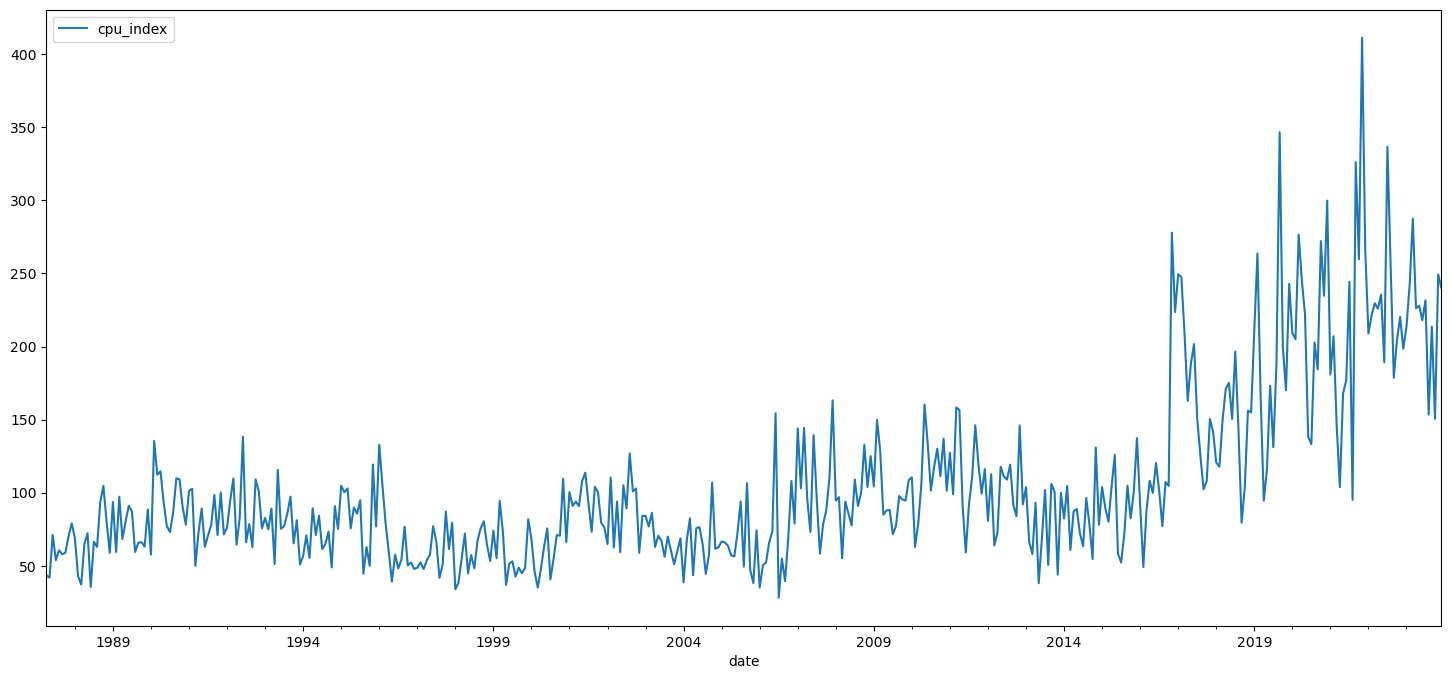

In [4]:
cpu.plot(figsize=(18,8))
plt.show()

### Load EMDAT

In [5]:
# Display available columns
emdat.columns.to_frame()

,0
DisNo.,DisNo.
Historic,Historic
Classification Key,Classification Key
Disaster Group,Disaster Group
Disaster Subgroup,Disaster Subgroup
Disaster Type,Disaster Type
Disaster Subtype,Disaster Subtype
External IDs,External IDs
Event Name,Event Name
ISO,ISO


In [6]:
# Check for null values
emdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10177 entries, 0 to 10176
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   DisNo.                                     10177 non-null  object 
 1   Historic                                   10177 non-null  object 
 2   Classification Key                         10177 non-null  object 
 3   Disaster Group                             10177 non-null  object 
 4   Disaster Subgroup                          10177 non-null  object 
 5   Disaster Type                              10177 non-null  object 
 6   Disaster Subtype                           10177 non-null  object 
 7   External IDs                               1628 non-null   object 
 8   Event Name                                 1889 non-null   object 
 9   ISO                                        10177 non-null  object 
 10  Country               

In [7]:
# Extract only required columns
emdat = emdat[['Country', 'Subregion', 'Region', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type','Start Year', 'Start Month', 'End Year', 'End Month']]
emdat.head()

,Country,Subregion,Region,Disaster Group,Disaster Subgroup,Disaster Type,Start Year,Start Month,End Year,End Month
0,Botswana,Sub-Saharan Africa,Africa,Natural,Climatological,Drought,1992,NaN,1992,NaN
1,Lesotho,Sub-Saharan Africa,Africa,Natural,Climatological,Drought,1992,6.0,1994,NaN
2,Mozambique,Sub-Saharan Africa,Africa,Natural,Climatological,Drought,1991,3.0,1992,3.0
3,Namibia,Sub-Saharan Africa,Africa,Natural,Climatological,Drought,1991,NaN,1992,3.0
4,United Republic of Tanzania,Sub-Saharan Africa,Africa,Natural,Climatological,Drought,1991,NaN,1992,NaN


In [8]:
# Remove empty rows (with no month labelled to the event)
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] = emdat['Start Year'].astype(str) + '-' + emdat['Start Month'].astype(int).astype(str).str.zfill(2)
emdat['Date'] = pd.to_datetime(emdat['Date'])

In [9]:
# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

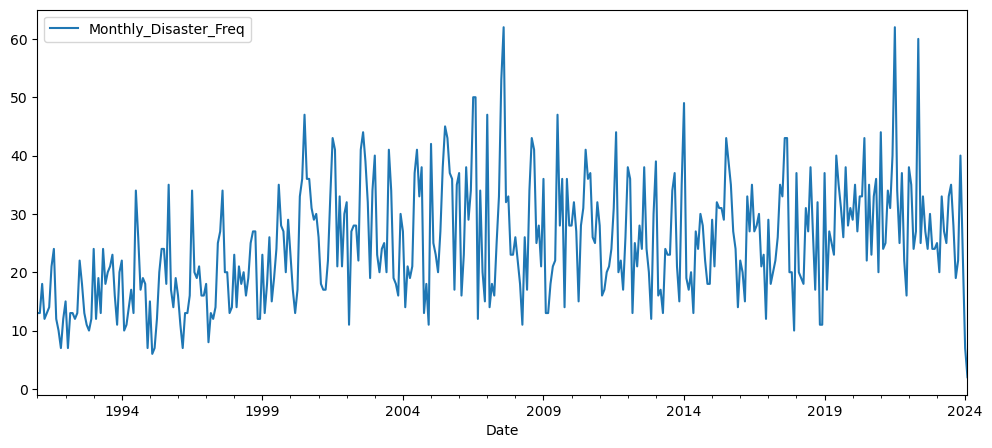

In [10]:
# plot series
emdat_mthly_freq.plot(figsize = (12,5))
plt.show()

### Load Natural Gas Future Prices

In [11]:
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%d/%m/%y')
natgas_futures.set_index('Date', inplace=True)
natgas_futures['daily_return'] = natgas_futures['natgas_future_price'].pct_change()
natgas_futures

,natgas_future_price,daily_return
Date,,
1994-01-13,2.194,NaN
1994-01-14,2.268,0.033728
1994-01-17,2.360,0.040564
1994-01-18,2.318,-0.017797
1994-01-19,2.252,-0.028473
...,...,...
2024-01-24,2.641,0.077959
2024-01-25,2.571,-0.026505
2024-01-26,2.712,0.054842


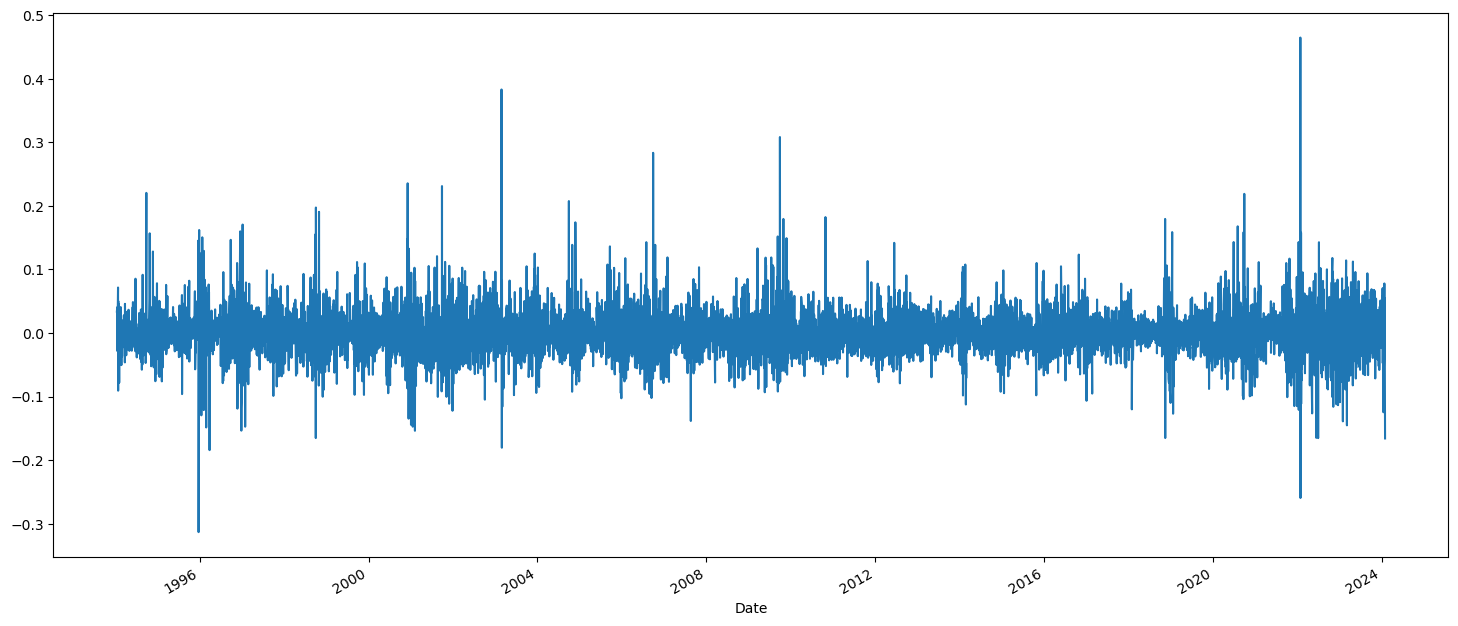

In [12]:
natgas_futures['daily_return'].plot(figsize=(18,8))
plt.show()

#### Aligning data to same window 01-94 to 12-23

In [13]:
# creating 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1994-01-13,2.194,NaN,1994-01,56.733087,22
1994-01-14,2.268,0.033728,1994-01,56.733087,22
1994-01-17,2.360,0.040564,1994-01,56.733087,22
1994-01-18,2.318,-0.017797,1994-01,56.733087,22
1994-01-19,2.252,-0.028473,1994-01,56.733087,22
...,...,...,...,...,...
2024-01-24,2.641,0.077959,2024-01,NaN,7
2024-01-25,2.571,-0.026505,2024-01,NaN,7
2024-01-26,2.712,0.054842,2024-01,NaN,7


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7546 entries, 1994-01-13 to 2024-01-30
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   natgas_future_price    7546 non-null   float64  
 1   daily_return           7545 non-null   float64  
 2   YYYY-MM                7546 non-null   period[M]
 3   cpu_index              7526 non-null   float64  
 4   Monthly_Disaster_Freq  7546 non-null   int64    
dtypes: float64(3), int64(1), period[M](1)
memory usage: 353.7 KB


In [15]:
# data = natgas_futures_data['daily_return']
# data = data.ffill()
data = data.dropna()
model = arch_model(data[['daily_return']], vol='Garch', p=1, q=1)
results = model.fit()

# Display the GARCH model summary
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6324948626644517e+19
Iteration:      2,   Func. Count:     17,   Neg. LLF: -14925.670828603548
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14925.670803660207
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                14925.7
Distribution:                  Normal   AIC:                          -29843.3
Method:            Maximum Likelihood   BIC:                          -29815.6
                                        No. Observations:                 7525
Date:                Fri, Feb 16 2024   Df Residuals:                     7524
Time:   

c:\Users\leeca\anaconda3\envs\quantco\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Calculate and Plot Weight

In [18]:
k = 8 # lags
w2=5

In [19]:
def weights (w2,k):
    den = 0
    w =[]
    for i in range(1,k+1):
        den += (1- i/k)**(w2-1)
    
    for j in range(1,k+1):
        num = (1- j/k)**(w2-1)
        w_ = num/den
        w.append(w_)
        
    return w

In [20]:
w=weights(w2,k)

In [21]:
w

[0.5134730538922155,
 0.2771599657827203,
 0.13366124893071002,
 0.05474764756201882,
 0.017322497861420018,
 0.003421727972626176,
 0.000213857998289136,
 0.0]

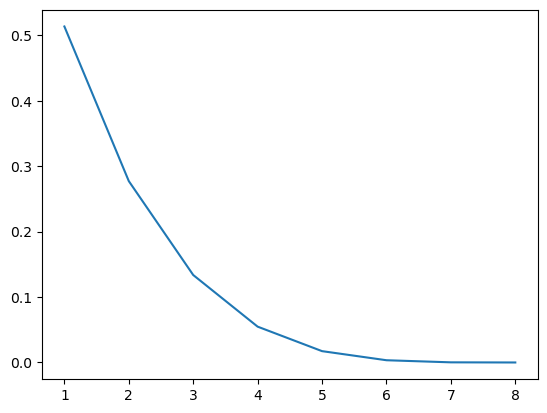

In [22]:
plt.plot(range(1,k+1),w)

### Realized Average Calculation

In [16]:
natgas_futures_rv = data[['daily_return']].resample('M').agg(lambda x: (x ** 2).sum())

natgas_futures_rv

,daily_return
Date,
1994-01-31,0.023208
1994-02-28,0.018283
1994-03-31,0.009809
1994-04-30,0.006717
1994-05-31,0.007172
...,...
2023-08-31,0.031140
2023-09-30,0.022613
2023-10-31,0.027795


### Linear Regression natgas_futures_rv against cpu with lags upto 8

In [17]:
cpu_data_x = data[['cpu_index']].resample('M').mean()
cpu_data_x

,cpu_index
Date,
1994-01-31,56.733087
1994-02-28,70.789021
1994-03-31,55.449487
1994-04-30,89.294281
1994-05-31,71.074022
...,...
2023-08-31,153.417951
2023-09-30,213.599284
2023-10-31,150.606362


In [23]:
Y = natgas_futures_rv.copy()
X = cpu_data_x.copy()

for k in range(1,k+1):
    X[f'cpu_index_lag{k}'] = X['cpu_index'].shift(k)
    X.dropna(inplace=True)
    
X.drop(columns=['cpu_index'],inplace=True)
X=X * w
X

,cpu_index_lag1,cpu_index_lag2,cpu_index_lag3,cpu_index_lag4,cpu_index_lag5,cpu_index_lag6,cpu_index_lag7,cpu_index_lag8
Date,,,,,,,,
1997-01-31,24.577314,14.490359,6.714473,4.202424,0.939803,0.164948,0.012349,0.0
1997-02-28,25.004752,13.266222,6.988020,2.750248,1.329673,0.185640,0.010309,0.0
1997-03-31,26.910721,13.496942,6.397677,2.862293,0.870196,0.262652,0.011603,0.0
1997-04-30,24.496780,14.525737,6.508942,2.620488,0.905647,0.171891,0.016416,0.0
1997-05-31,27.662417,13.222751,7.005081,2.666063,0.829139,0.178893,0.010743,0.0
...,...,...,...,...,...,...,...,...
2023-08-31,118.972045,60.433575,30.466818,12.384023,4.980730,0.828251,0.045673,0.0
2023-09-30,78.775984,64.218147,29.144278,12.479209,3.918382,0.983848,0.051766,0.0
2023-10-31,109.677476,42.521314,30.969399,11.937496,3.948500,0.774001,0.061490,0.0


In [27]:
Y= Y.tail(X.shape[0])
X = sm.add_constant(X)

In [28]:
model = sm.OLS(Y, X)
results = model.fit()

# Print regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           daily_return   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.250
Date:                Fri, 16 Feb 2024   Prob (F-statistic):            0.00240
Time:                        01:58:26   Log-Likelihood:                 671.41
No. Observations:                 324   AIC:                            -1327.
Df Residuals:                     316   BIC:                            -1297.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0171      0.004      4.

c:\Users\leeca\anaconda3\envs\quantco\lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


---
# Archive

### Simulated Disaster Monthly Frequencies

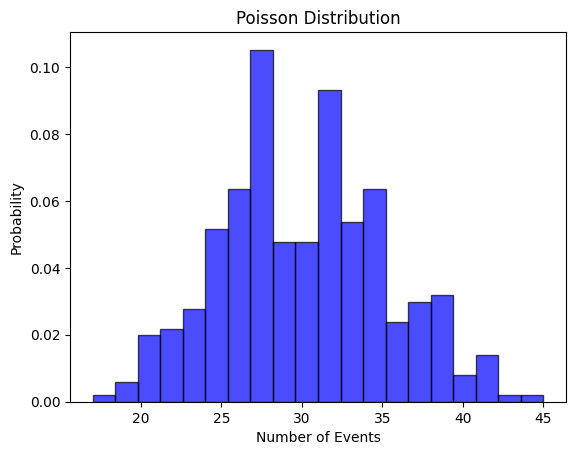

In [82]:
import numpy as np
import matplotlib.pyplot as plt

lambda_parameter = 30

events = np.random.poisson(lambda_parameter, size=30*12)

plt.hist(events, bins=20, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Poisson Distribution')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.show()

In [83]:
date_range = pd.date_range(start='1994-01-01', periods=30*12, freq='M')
sim_disaster_data = pd.DataFrame({'Date': date_range, 'Monthly_Disaster_Freq': events})
sim_disaster_data.set_index('Date', inplace=True)
sim_disaster_data

,Monthly_Disaster_Freq
Date,
1994-01-31,28
1994-02-28,29
1994-03-31,24
1994-04-30,27
1994-05-31,32
...,...
2023-08-31,31
2023-09-30,31
2023-10-31,33


<Axes: xlabel='Date'>

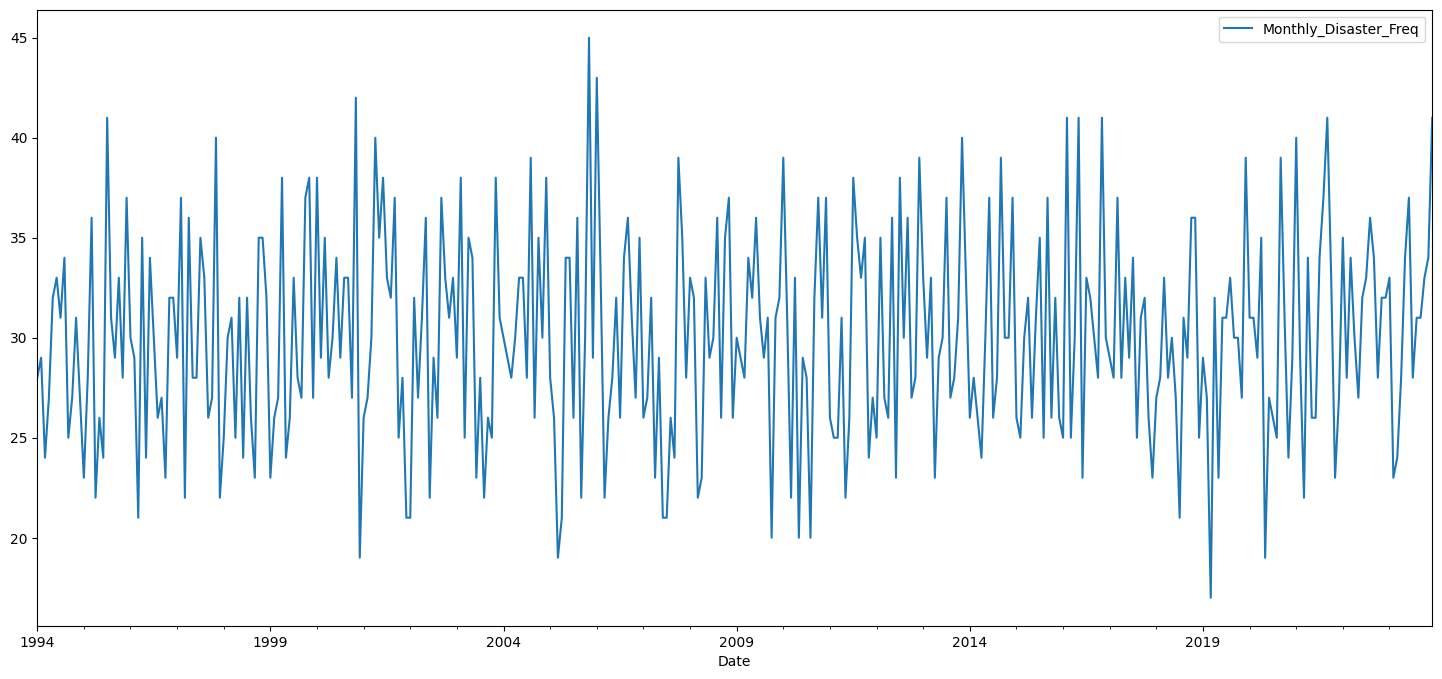

In [84]:
sim_disaster_data.plot(figsize=(18,8))